In [1]:
import sklearn
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
from pandas import Series, DataFrame

import scipy.interpolate as si
import statsmodels.api as api

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
df1 = pd.read_csv('data/strongdrink.txt')
df1.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


#### Problem 1.a

In [3]:
X = df1[["alco", "malic", "tot_phen", "color_int"]]
y = df1['cultivar']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

In [7]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

clf_coef = np.concatenate((clf.intercept_.reshape(1, 3), clf.coef_.T))

row_name = ['beta0', 'beta1', 'beta2', 'beta3', 'beta4']
lst = []
for i in range(len(clf_coef.T)):
    lst.append(dict(zip(row_name, clf_coef.T[i])))

j1 = pd.Series(lst[0])
j2 = pd.Series(lst[1])
coef_df = pd.DataFrame({ "j1" : j1, "j2": j2})
print(coef_df)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              j1         j2
beta0 -24.027621  22.780737
beta1   1.701735  -1.466297
beta2  -0.265788  -0.332953
beta3   1.224101   0.663556
beta4   0.022506  -0.922682
              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [14]:
print(" Category    The error rate \n Category 1      0.13\n Category 2      0\n Category 3      0")

 Category    The error rate 
 Category 1      0.13
 Category 2      0
 Category 3      0


##### Both Category 2 and Category 3 have error rate of zero, but Category 3 has lower f1 score, which means that it has the most accurate prediction

In [19]:
df1.groupby("cultivar").count()["alco"]

cultivar
1    59
2    71
3    46
Name: alco, dtype: int64

##### From the count of observation, the category 2 dominates the sample. Thus, the most accurate prediction is not the observation with the highest frequency.

In [5]:
print(f'Test set MSE is {mean_squared_error(y_test, y_pred)}')

Test set MSE is 0.045454545454545456


#### Problem 1.b

In [58]:
Xvar = X.values
yvar = y.values
N_loo = Xvar.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvar)
MSE_vec = np.zeros(N_loo)
y_pred = np.zeros(N_loo)

# This loop will take 20 or 30 seconds
for train_index, test_index in loo.split(Xvar):
    X_train, X_test = Xvar[train_index], Xvar[test_index]
    y_train, y_test = yvar[train_index], yvar[test_index]
    LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    MSE_vec[test_index] = (y_test - y_pred[test_index]) ** 2
    #print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()
print('test estimate MSE loocv=', MSE_loo,
      ', test estimate MSE standard err=', MSE_loo_std)

test estimate MSE loocv= 0.09659090909090909 , test estimate MSE standard err= 0.39426250589387657


In [59]:
print(classification_report(yvar, y_pred))

              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



In [21]:
print(" Category    The error rate \n Category 1      0.1\n Category 2      0.09\n Category 3      0.04")

 Category    The error rate 
 Category 1      0.1
 Category 2      0.09
 Category 3      0.04


##### Compared to the results from part (a), the error rate of both Category 2 and Category 3 rise.

#### Problem 1.c

In [60]:
kf = KFold(n_splits=4, shuffle=True, random_state=10)
kf.get_n_splits(Xvar)

MSE_vec_kf = np.zeros(4)
y_pred = np.zeros(len(yvar))

k_ind = int(0)
for train_index, test_index in kf.split(Xvar):
    # print("TRAIN:", train_index, "TEST:", test_index)
    # print('k index=', k_ind)
    X_train, X_test = Xvar[train_index], Xvar[test_index]
    y_train, y_test = yvar[train_index], yvar[test_index]
    LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial')
    LogReg.fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = ((y_test - y_pred[test_index]) ** 2).mean()
    # print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()
print('test estimate MSE k-fold=', MSE_kf,
      'test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.10795454545454546 test estimate MSE standard err= 0.07429941381035239


In [62]:
print(classification_report(yvar, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.93      0.90        59
           2       0.91      0.87      0.89        71
           3       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



In [22]:
print(" Category    The error rate \n Category 1      0.13\n Category 2      0.09\n Category 3      0.04")

 Category    The error rate 
 Category 1      0.13
 Category 2      0.09
 Category 3      0.04


##### The error rate of Category 2 and 3 keep the same  with LOOCV, but the Category 1 increases and is the same as part (a).

#### Problem2.a

In [27]:
df2 = pd.read_csv('data/CoolIndex.txt', header = None)
df2.head()

,0,1
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


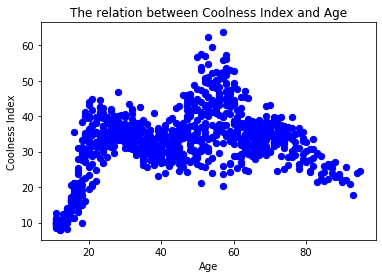

In [28]:
fig, ax = plt.subplots()
plt.scatter(df2[0], df2[1], s=40, c='blue', marker='o',
            label='Data')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('The relation between Coolness Index and Age')
plt.show()
age = pd.Series(df2[0])
coolInd = pd.Series(df2[1])
df2 = pd.DataFrame({ "age" : age, "coolInd" : coolInd})

#### Problem 2.b

In [30]:
cols = ["bin1", "bin2", "bin3", "bin4", "bin5"]
end = [22, 40, 59, 77, 96]
new_df = pd.DataFrame({ cols[c]: [ int(i) for i in ( age < end[c]) ] for c in range(len(cols))})
for i in range(4, 0, -1):
    new_df.iloc[:, i] = new_df.iloc[:, i] - new_df.iloc[:, i - 1]
new_df

,bin1,bin2,bin3,bin4,bin5
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
951,0,0,0,0,1
952,0,0,0,0,1
953,0,0,0,0,1
954,0,0,0,0,1


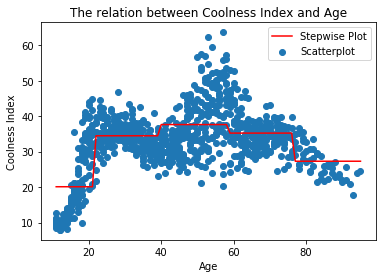

In [40]:
result_step = api.OLS(coolInd, new_df).fit()
plt.scatter(age, coolInd, label='Scatterplot')
plt.plot(age, result_step.predict(), color = 'r', label = "Stepwise Plot")
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('The relation between Coolness Index and Age')
plt.legend()
plt.show()

In [35]:
result_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      1   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Tue, 25 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        21:42:19   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bin1          20.1025      0.562     35.746      0.000      18.999      21.206
bin2          34.4758      0.431     80.006      0.000      33.630      35.321
bin3          37.6351      0.424     88.814      0.000      36.804      38.467
bin4          35.2254      0.485     72.560      0.000      34.273      36.178
bin5          27.2964      0.936     29.175      0.000      25.460      29.132
==============================================================================
Omnibus:                       80.102   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.718
Skew:                           0.714   Prob(JB):                     8.17e-23
Kurtosis:                       3.719   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### The coefficient of five  bins are listed in the table above. Since people at the age of 73 fall in the fourth bin, hence the predicted coolness is 35.2254

#### Problem 2.c

In [36]:
knots = [22, 40, 59, 77]
mean_ind = df2.groupby("age").mean()["coolInd"]
new_df2 = pd.DataFrame({ "age": list(range(11, 96)), "coolInd" : mean_ind.values})
print(new_df2)
spline_lin = si.LSQUnivariateSpline(np.array(new_df2["age"]), np.array(new_df2["coolInd"]), t=knots, k=1)

    age    coolInd
0    11  10.110237
1    12   9.365623
2    13  10.015882
3    14  11.747109
4    15  15.434739
..  ...        ...
80   91  23.821051
81   92  20.898071
82   93  17.756216
83   94  23.857727
84   95  24.447999

[85 rows x 2 columns]


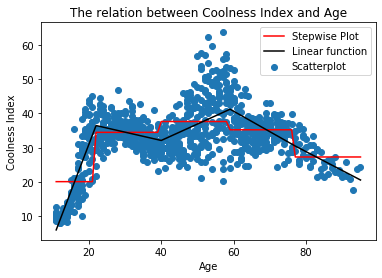

In [43]:
plt.scatter(age, coolInd, label='Scatterplot')
plt.plot(age, result_step.predict(), color = 'r', label = "Stepwise Plot")
plt.plot(new_df2["age"], spline_lin(new_df2["age"]), color = 'black', label = "Linear function")
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('The relation between Coolness Index and Age')
plt.legend()
plt.show()

In [46]:
print(f"The predicted coolness Index of the person at the age of 73 is {float(spline_lin(73))}")

The predicted coolness Index of the person at the age of 73 is 32.86784862349653


#### Problem 2.d

In [48]:
spline_cub = si.LSQUnivariateSpline(np.array(new_df2["age"]), np.array(new_df2["coolInd"]), t=knots, k=3)

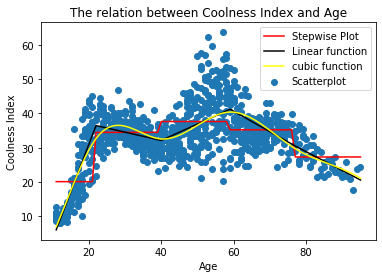

In [49]:
plt.scatter(age, coolInd, label='Scatterplot')
plt.plot(age, result_step.predict(), color = 'r', label = "Stepwise Plot")
plt.plot(new_df2["age"], spline_lin(new_df2["age"]), color = 'black', label = "Linear function")
plt.plot(new_df2["age"], spline_cub(new_df2["age"]), color = 'yellow', label = "cubic function")
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('The relation between Coolness Index and Age')
plt.legend()
plt.show()

In [50]:
print(f"The predicted coolness Index of the person at the age of 73 is {float(spline_cub(73))}")

The predicted coolness Index of the person at the age of 73 is 32.642301066279764
